<h1 style="text-align:center; color:#6A5ACD; font-weight:bold; font-size:38px;">Brain Tumor Classification With Pytorch</h1>


<h1 style="text-align:left; color:#6A5ACD; font-weight:bold; font-size:28px; font-family:Arial, sans-serif;">Import Libraries</h1>

In [ ]:
# utils
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
# torch
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models, datasets

#Remove Warnings
import warnings
warnings.filterwarnings('ignore')

<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#6A5ACD; overflow:hidden"><b>Reading The Data</b></div>

In [ ]:
# 1) Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive

 022A4992.JPG
 022A4993.JPG
 022A4994.JPG
 022A4995.JPG
 022A4996.JPG
 022A4997.JPG
 022A4998.JPG
 022A4999.JPG
 022A5000.JPG
 022A5001.JPG
 022A5002.JPG
 022A5003.JPG
 022A5004.JPG
 022A5005.JPG
 022A5006.JPG
 022A5008.JPG
 022A5009.JPG
 022A5011.JPG
 022A5012.JPG
 022A5013.JPG
 022A5014.JPG
 022A5015.JPG
 022A5016.JPG
 022A5017.JPG
 022A5018.JPG
 022A5019.JPG
 022A5020.JPG
 022A5021.JPG
 022A5022.JPG
 022A5023.JPG
 022A5024.JPG
 022A5025.JPG
 022A5026.JPG
 022A5027.JPG
 022A5028.JPG
 022A5033.JPG
 022A5034.JPG
 022A5035.JPG
 022A5036.JPG
 022A5038.JPG
 022A5039.JPG
 022A5040.JPG
 022A5041.JPG
 022A5042.JPG
 022A5043.JPG
 022A5044.JPG
 022A5046.JPG
 022A5047.JPG
 022A5048.JPG
 022A5049.JPG
 022A5050.JPG
 022A5051.JPG
 022A5052.JPG
 022A5053.JPG
 022A5054.JPG
 022A5055.JPG
 022A5058.JPG
 022A5061.JPG
 022A5062.JPG
 022A5065.JPG
 022A5066.JPG
 022A5067.JPG
 022A5068.JPG
 022A5069.JPG
 022A5070.JPG
 022A5071.JPG
 022A5072.JPG
 022A5073.JPG
 022A5075.JPG
 022A5077.JPG
 022A5078.JPG
 022A5

In [ ]:
import os

# 3) Point to your data
base_directory = '/content/drive/MyDrive/dataset_Braintumor'

# Quick check:
print("Subfolders in dataset_Braintumor:", os.listdir(base_directory))
# should print ['Training', 'Testing']


Subfolders in dataset_Braintumor: ['.DS_Store', 'Training', 'Testing']


In [ ]:
import os
import torch
import pandas as pd

base_directory = '/content/drive/MyDrive/dataset_Braintumor'
train, test = 'Training', 'Testing'
target_size = (224, 224)
random_state = 42
batch_size = 32
num_classes = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

label_map = {
    'notumor':    0,
    'glioma':     1,
    'meningioma': 2,
    'pituitary':  3
}

categories = list(label_map.keys())

def create_df(split):
    rows = []
    split_dir = os.path.join(base_directory, split)
    for cat in categories:
        cat_dir = os.path.join(split_dir, cat)
        for fname in os.listdir(cat_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                rows.append({
                    'filepath': os.path.join(cat_dir, fname),
                    'label':    cat,
                    'label_id': label_map[cat]
                })
    return pd.DataFrame(rows)

train_df = create_df(train)
test_df  = create_df(test)

print(f"Device: {device}")
print(f"Train set: {len(train_df)} images")
print(train_df['label'].value_counts())
print(f"Test  set: {len(test_df)} images")
print(test_df['label'].value_counts())


Device: cpu
Train set: 5722 images
label
notumor       1595
pituitary     1467
meningioma    1339
glioma        1321
Name: count, dtype: int64
Test  set: 1311 images
label
notumor       405
meningioma    306
glioma        300
pituitary     300
Name: count, dtype: int64


In [ ]:
def display_images(dataset_type, num_images=4, image_size=(224, 224)):

    dataset_path = os.path.join(base_directory, dataset_type)

    fig, axes = plt.subplots(len(categories), num_images, figsize=(15, 10))

    for row, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        image_filenames = random.sample(os.listdir(category_path), num_images)  # Select random images

        for col, image_filename in enumerate(image_filenames):
            while image_filename == '.DS_Store':
                image_filename = random.sample(os.listdir(category_path), 1)[0]
            image_path = os.path.join(category_path, image_filename)
            image = Image.open(image_path).resize(image_size)
            axes[row, col].imshow(image, cmap='gray')
            axes[row, col].axis('off')
            axes[row, col].set_title(f"{category}")

    plt.tight_layout()
    plt.show()

## Exploring the Data

In [ ]:
def plot_class_distribution(dataset_type):
    path = os.path.join(base_directory, dataset_type)
    counts = [len(os.listdir(os.path.join(path, cat))) for cat in categories]

    plt.bar(categories, counts, color = ['navy', 'teal', 'darkorange', 'crimson'])
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(f"{dataset_type.capitalize()} Set Distribution")
    plt.show()

### Train set

In [ ]:
plot_class_distribution(train)

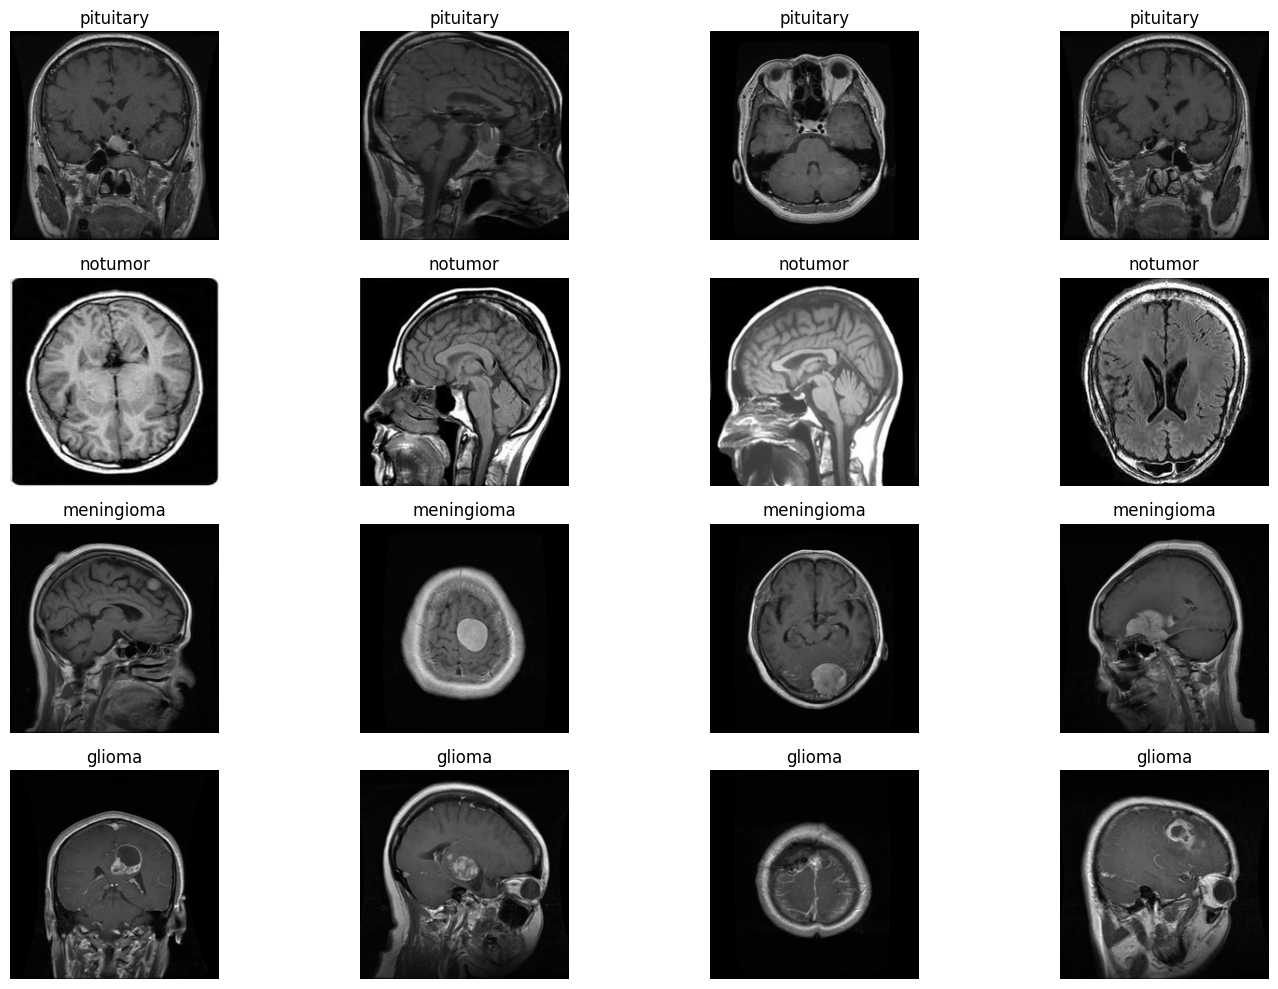

In [ ]:
display_images(train)

### Test Set

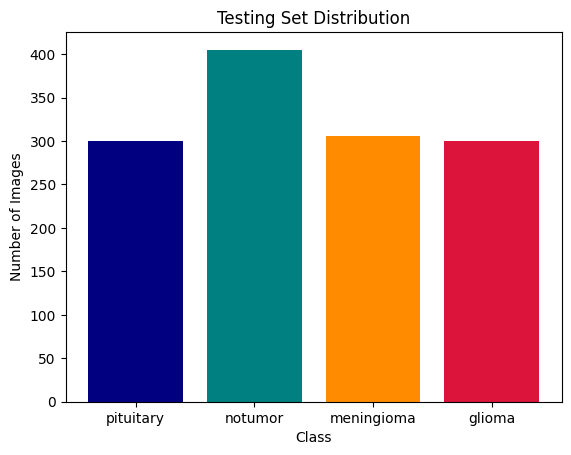

In [ ]:
plot_class_distribution(test)

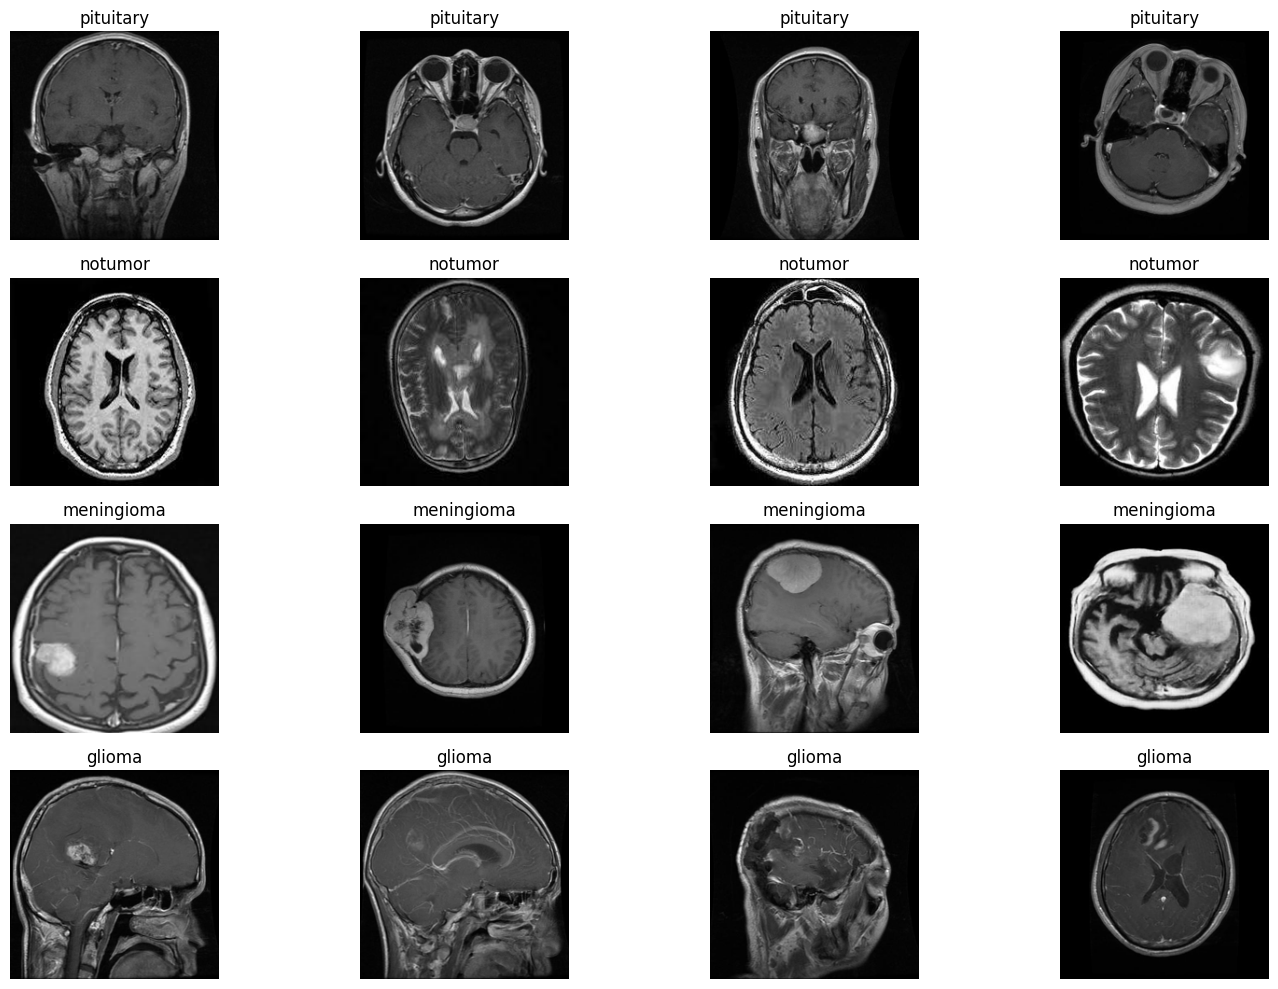

In [ ]:
display_images(test)

<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#6A5ACD; overflow:hidden"><b>Preparing the Data</b></div>

In [ ]:
def create_dataset(path):
    my_list = []
    for category in categories:
        category_path = os.path.join(path, category)
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            # Ensure we're only adding image files
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                my_list.append([file_path, category])
    return pd.DataFrame(my_list, columns=['file_path', 'label'])

In [ ]:
train_df = create_dataset(base_directory+'/'+train)
test_df = create_dataset(base_directory+'/'+test)

NameError: name 'base_directory' is not defined

In [ ]:
train_df['label'] = train_df['label'].map(label_map)
test_df['label'] = test_df['label'].map(label_map)

## Create Class ImageDataset

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

## Data Augmentation

In [ ]:
train_transform = transforms.Compose([

   transforms.Resize(target_size),
   transforms.RandomHorizontalFlip(),
   transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
   transforms.ColorJitter(brightness=(0.8, 1.2)),
   transforms.RandomRotation(10),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [ ]:
test_df_split, val_df_split = train_test_split(test_df, test_size=0.5, random_state=random_state)
# Reset indices for consistency
test_df_split = test_df_split.reset_index(drop=True)
val_df_split = val_df_split.reset_index(drop=True)

In [ ]:
train_dataset = ImageDataset(train_df, transform=train_transform)
val_dataset = ImageDataset(val_df_split, transform=test_transform)
test_dataset = ImageDataset(test_df_split, transform=test_transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#6A5ACD; overflow:hidden"><b>Model 1 (Custom CNN)</b></div>

In [ ]:
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # Conv Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # (B, 32, 224, 224)

        # Conv Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (B, 64, 112, 112)

        # Conv Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # (B, 128, 56, 56)

        # Conv Block 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # (B, 256, 28, 28)

        # Conv Block 5
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # (B, 256, 14, 14)

        # Final shape after pool: (B, 256, 7, 7)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # (B, 32, 112, 112)
        x = self.pool(self.relu(self.conv2(x)))  # (B, 64, 56, 56)
        x = self.pool(self.relu(self.conv3(x)))  # (B, 128, 28, 28)
        x = self.pool(self.relu(self.conv4(x)))  # (B, 256, 14, 14)
        x = self.pool(self.relu(self.conv5(x)))  # (B, 256, 7, 7)

        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

In [ ]:
model = BrainTumorCNN(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, name='model', patience=7):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_loss = float("inf")
    tolerance = 0  # Counter for early stopping
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
        print("#" * 80)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'best_brain_tumor_{name}.pth')
            tolerance = 0
        else:
            tolerance += 1
            if tolerance >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    return history


In [ ]:
def test_model(model, test_loader, num_images_to_show=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    all_preds = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect for later analysis
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(images.cpu())  # Store images for visualization

    test_acc = 100 * correct / total

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test Accuracy: {test_acc:.2f}%\n")

    # Print classification report
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=categories))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=categories, yticklabels=categories)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [ ]:
print("Starting training...")
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=60)

Starting training...
Epoch [1/60]
Train Loss: 1.0012, Train Accuracy: 56.23%
Val Loss: 0.7859, Val Accuracy: 71.65%
################################################################################
Epoch [2/60]
Train Loss: 0.6410, Train Accuracy: 74.02%
Val Loss: 0.5350, Val Accuracy: 80.03%
################################################################################
Epoch [3/60]
Train Loss: 0.5371, Train Accuracy: 79.27%
Val Loss: 0.5327, Val Accuracy: 78.96%
################################################################################
Epoch [4/60]
Train Loss: 0.4356, Train Accuracy: 83.44%
Val Loss: 0.6230, Val Accuracy: 75.00%
################################################################################
Epoch [5/60]
Train Loss: 0.3515, Train Accuracy: 87.11%
Val Loss: 0.2787, Val Accuracy: 88.87%
################################################################################
Epoch [6/60]
Train Loss: 0.2876, Train Accuracy: 89.39%
Val Loss: 0.3471, Val Accuracy: 86.43%
####

In [ ]:
def plot_training_history(history, model_name="model"):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

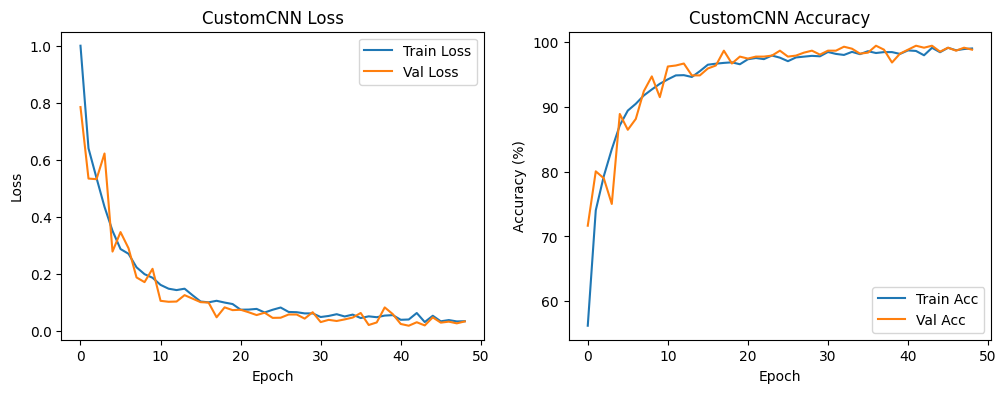

In [ ]:
plot_training_history(history, model_name="CustomCNN")

## Evaluation


Loading best model for testing...
Test Accuracy: 99.54%

Classification Report:

              precision    recall  f1-score   support

   pituitary       1.00      1.00      1.00       197
     notumor       1.00      0.99      0.99       151
  meningioma       0.99      1.00      0.99       158
      glioma       0.99      0.99      0.99       149

    accuracy                           1.00       655
   macro avg       1.00      1.00      1.00       655
weighted avg       1.00      1.00      1.00       655



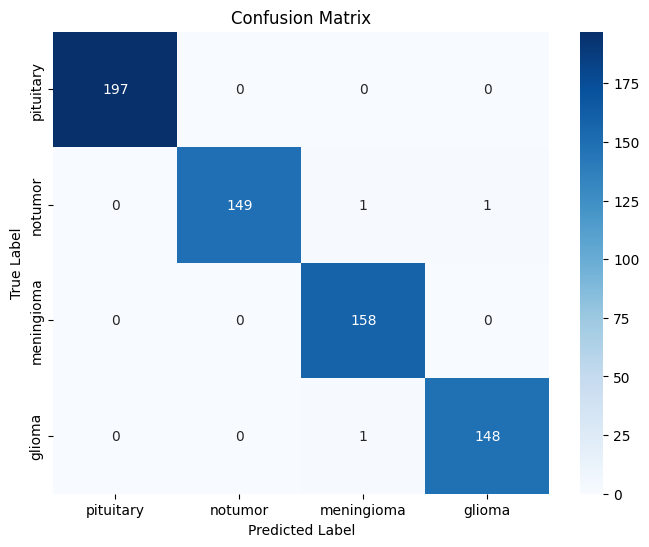

In [ ]:
print("\nLoading best model for testing...")
model.load_state_dict(torch.load('best_brain_tumor_model.pth'))
test_model(model, test_loader)

In [ ]:
def visualize_predictions(model, test_loader, num_images=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct_images, incorrect_images = [], []
    correct_labels, incorrect_labels = [], []
    correct_preds, incorrect_preds = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Separate correct and incorrect predictions
            for i in range(len(predicted)):
                if predicted[i] == labels[i]:
                    correct_images.append(images[i])
                    correct_labels.append(labels[i].cpu().item())
                    correct_preds.append(predicted[i].cpu().item())
                else:
                    incorrect_images.append(images[i])
                    incorrect_labels.append(labels[i].cpu().item())
                    incorrect_preds.append(predicted[i].cpu().item())

    # Visualization
    # Unnormalize using your mean and std
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)

    num_cols = num_images // 2
    plt.figure(figsize=(15, 7))

    # Display correct predictions
    for i, img_tensor in enumerate(correct_images[:num_images // 2]):
        img_tensor = img_tensor * std + mean  # reverse normalization
        img = np.clip(img_tensor.permute(1, 2, 0).cpu().numpy(), 0, 1)
        plt.subplot(2, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f"True: {categories[correct_labels[i]]}\nPred: {categories[correct_preds[i]]}", color='green', fontsize=15)
        plt.axis('off')

    # Display incorrect predictions
    for i, img_tensor in enumerate(incorrect_images[:num_images // 2]):
        if i >= len(incorrect_images):
            plt.axis('off')
            continue
        img_tensor = img_tensor * std + mean  # reverse normalization
        img = np.clip(img_tensor.permute(1, 2, 0).cpu().numpy(), 0, 1)
        plt.subplot(2, num_cols, num_cols + i + 1)
        plt.imshow(img)
        plt.title(f"True: {categories[incorrect_labels[i]]}\nPred: {categories[incorrect_preds[i]]}", color='red', fontsize=15)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


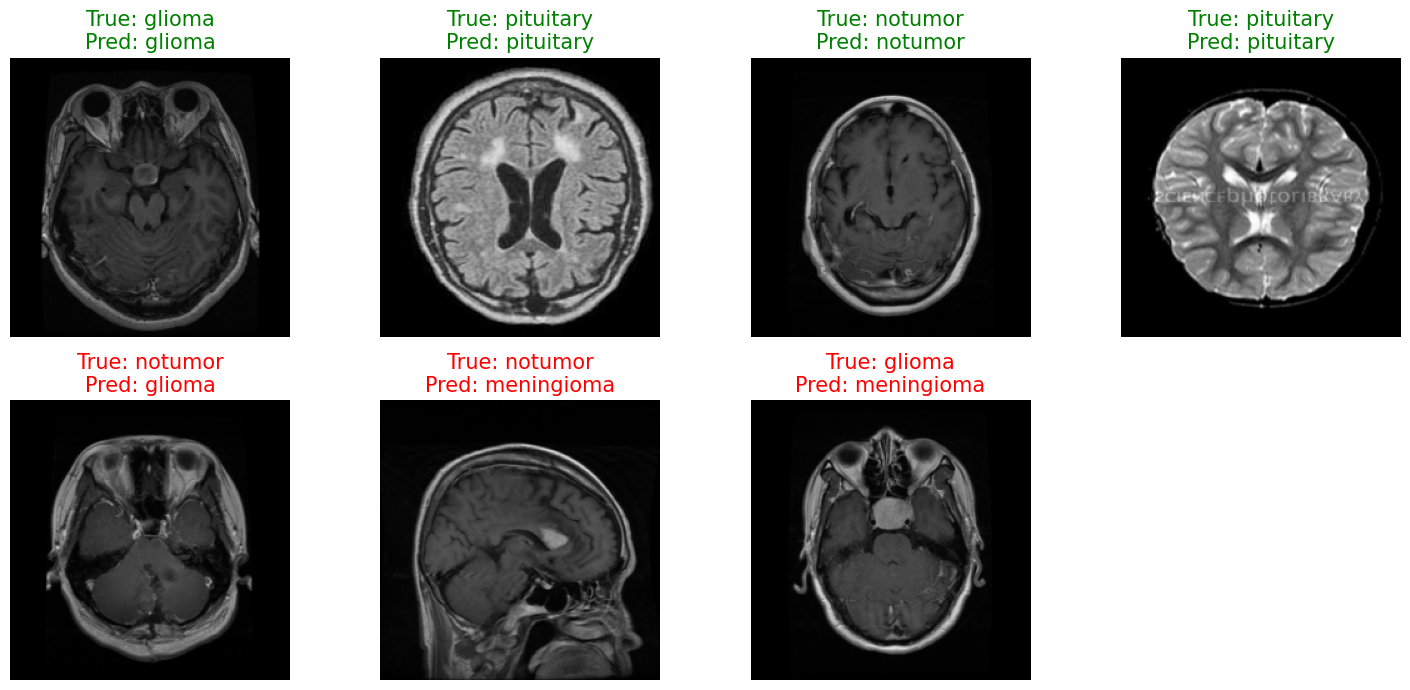

In [ ]:
visualize_predictions(model, test_loader, 8)

## Model Performance and Future Work

The **Custom CNN** model achieved a **satisfactory accuracy of 99.54%**, which is a strong result and indicates good performance on the classification task. However, to further explore the potential for improvement and leverage transfer learning, I would like to experiment with a **pretrained model in PyTorch**.


<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#6A5ACD; overflow:hidden"><b>Model 2 (ResNet18)</b></div>

<div style="text-align:center;">
  <img src="https://d2l.ai/_images/residual-block.svg" width="500px">
</div>

In [ ]:
# Load pretrained ResNet-18 model
model2 = models.resnet18(pretrained=True)

In [ ]:
# Freeze all layers except the final fully connected layer
for param in model2.parameters():
    param.requires_grad = False

In [ ]:
num_ftrs = model2.fc.in_features
model2.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 4)
)

NameError: name 'model2' is not defined

In [ ]:
# Move model to device
model2 = model2.to(device)

In [ ]:
optimizer = optim.Adam(model2.fc.parameters(), lr=0.001)

NameError: name 'optim' is not defined

In [ ]:
print("Starting training...")
history = train_model(model2, train_loader, val_loader, criterion, optimizer, num_epochs=60, name='resnet18')

Starting training...
Epoch [1/60]
Train Loss: 0.6400, Train Accuracy: 74.11%
Val Loss: 0.5267, Val Accuracy: 78.35%
################################################################################
Epoch [2/60]
Train Loss: 0.4575, Train Accuracy: 82.32%
Val Loss: 0.4183, Val Accuracy: 82.77%
################################################################################
Epoch [3/60]
Train Loss: 0.4252, Train Accuracy: 83.65%
Val Loss: 0.4349, Val Accuracy: 82.47%
################################################################################
Epoch [4/60]
Train Loss: 0.4052, Train Accuracy: 84.72%
Val Loss: 0.3837, Val Accuracy: 85.06%
################################################################################
Epoch [5/60]
Train Loss: 0.3919, Train Accuracy: 84.68%
Val Loss: 0.4210, Val Accuracy: 83.54%
################################################################################
Epoch [6/60]
Train Loss: 0.3722, Train Accuracy: 85.82%
Val Loss: 0.3860, Val Accuracy: 83.99%
####

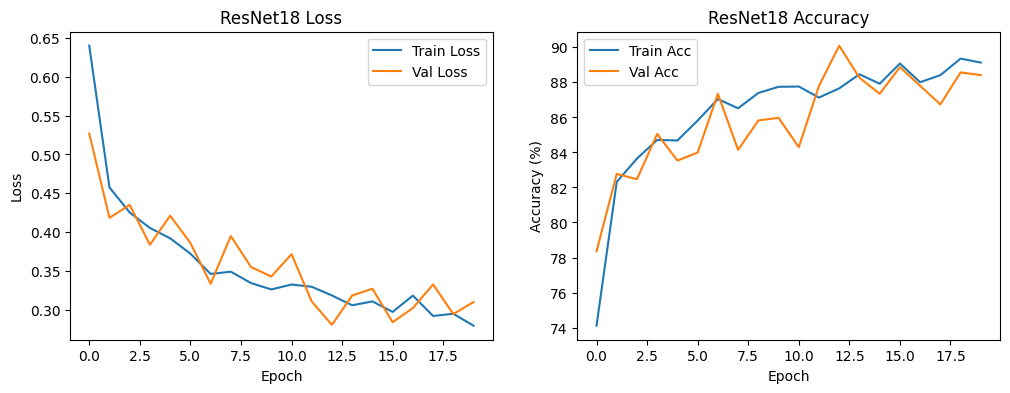

In [ ]:
plot_training_history(history, model_name="ResNet18")


Loading best model for testing...
Test Accuracy: 89.16%

Classification Report:

              precision    recall  f1-score   support

   pituitary       0.93      0.95      0.94       197
     notumor       0.90      0.85      0.87       151
  meningioma       0.79      0.78      0.79       158
      glioma       0.94      0.97      0.95       149

    accuracy                           0.89       655
   macro avg       0.89      0.89      0.89       655
weighted avg       0.89      0.89      0.89       655



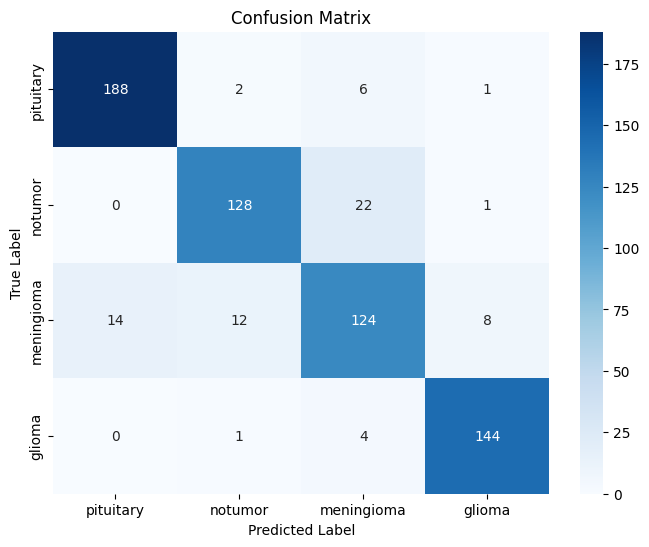

In [ ]:
print("\nLoading best model for testing...")
model2.load_state_dict(torch.load('best_brain_tumor_resnet18.pth'))
test_model(model2, test_loader)

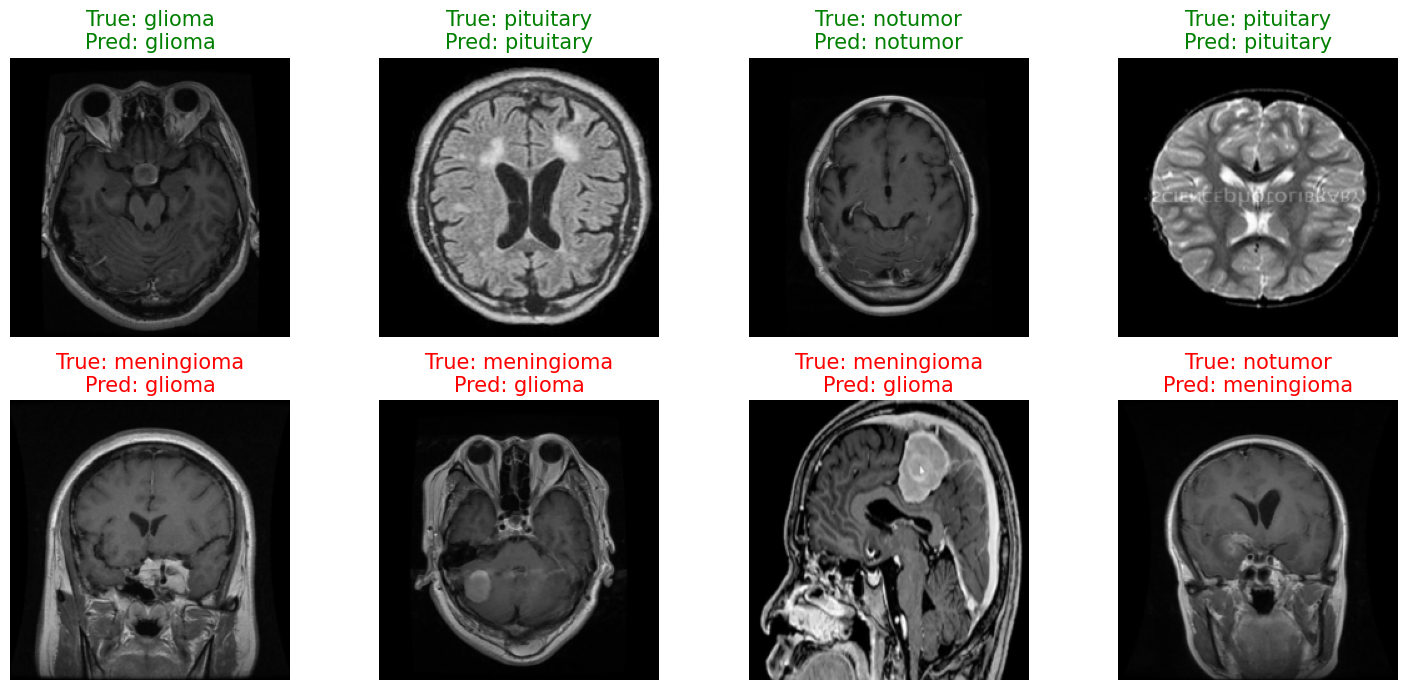

In [ ]:
visualize_predictions(model2, test_loader, 8)

## FineTuning

In [ ]:
# Unfreeze layer4 and fc
for name, param in model2.named_parameters():
    if 'layer4' in name or 'layer3' in name or 'fc' in name:
        param.requires_grad = True

In [ ]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()), lr=1e-4)

In [ ]:
print("Starting training...")
history = train_model(model2, train_loader, val_loader, criterion, optimizer, num_epochs=30, name='resnet18_finetuned')

Starting training...
Epoch [1/30]
Train Loss: 0.2434, Train Accuracy: 90.65%
Val Loss: 0.1652, Val Accuracy: 94.21%
################################################################################
Epoch [2/30]
Train Loss: 0.1298, Train Accuracy: 95.15%
Val Loss: 0.1590, Val Accuracy: 93.90%
################################################################################
Epoch [3/30]
Train Loss: 0.1024, Train Accuracy: 96.55%
Val Loss: 0.1003, Val Accuracy: 95.88%
################################################################################
Epoch [4/30]
Train Loss: 0.0776, Train Accuracy: 97.48%
Val Loss: 0.0362, Val Accuracy: 98.48%
################################################################################
Epoch [5/30]
Train Loss: 0.0708, Train Accuracy: 97.76%
Val Loss: 0.1519, Val Accuracy: 95.73%
################################################################################
Epoch [6/30]
Train Loss: 0.0610, Train Accuracy: 98.07%
Val Loss: 0.0980, Val Accuracy: 96.19%
####

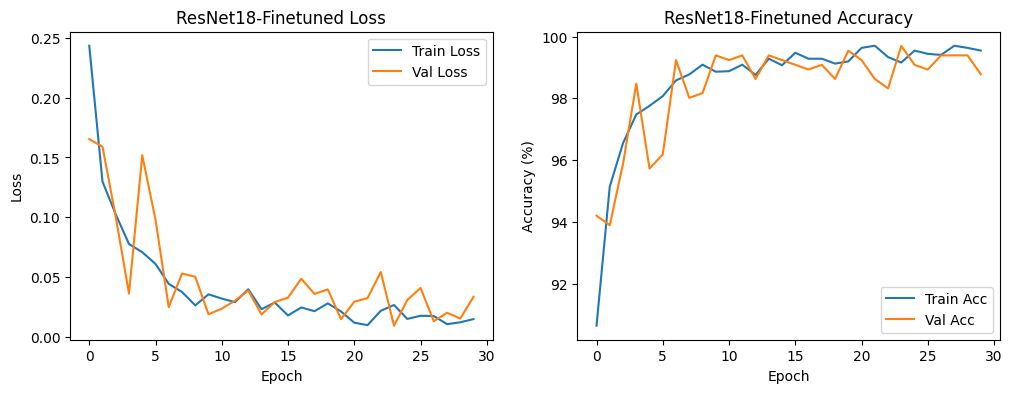

In [ ]:
plot_training_history(history, model_name="ResNet18-Finetuned")


Loading best model for testing...
Test Accuracy: 99.69%

Classification Report:

              precision    recall  f1-score   support

   pituitary       1.00      0.99      1.00       197
     notumor       0.99      1.00      1.00       151
  meningioma       0.99      0.99      0.99       158
      glioma       1.00      1.00      1.00       149

    accuracy                           1.00       655
   macro avg       1.00      1.00      1.00       655
weighted avg       1.00      1.00      1.00       655



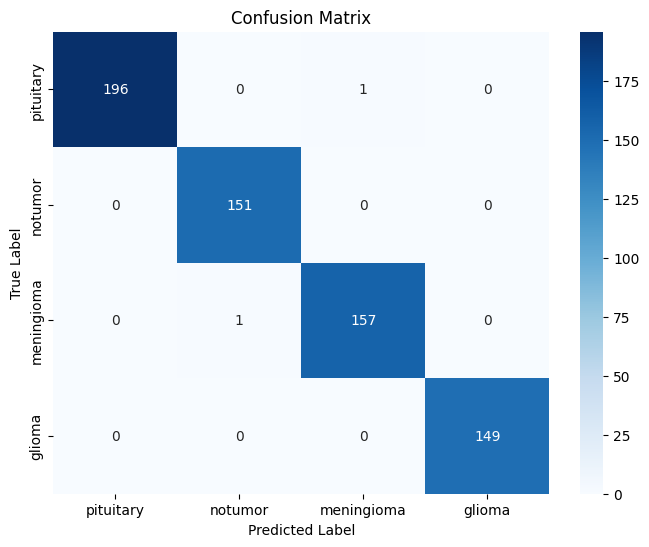

In [ ]:
print("\nLoading best model for testing...")
model2.load_state_dict(torch.load('best_brain_tumor_resnet18_finetuned.pth'))
test_model(model2, test_loader)

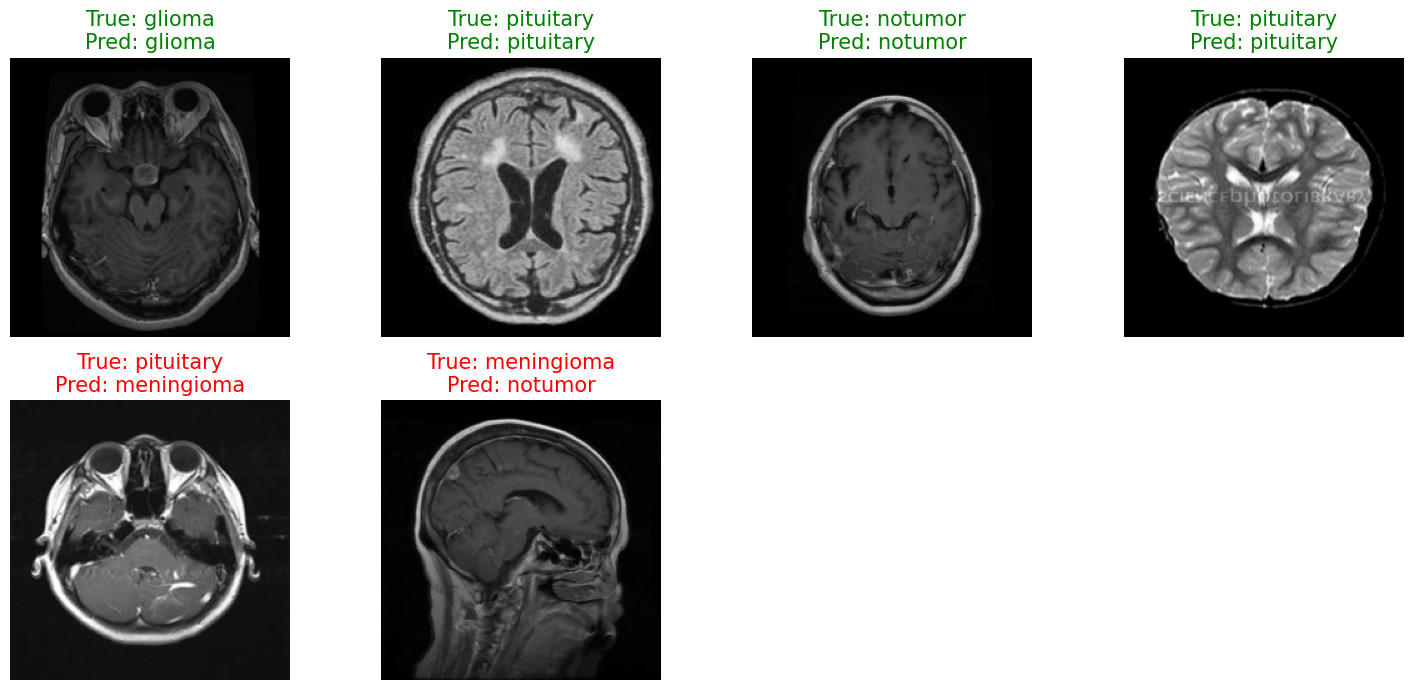

In [ ]:
visualize_predictions(model2, test_loader, 8)